# 训练神经网络

我们在上个部分构建的神经网络了解的信息很少，它不知道关于我们的手写数字的任何信息。具有非线性激活函数的神经网络就像通用函数逼近器一样。某些函数会将输入映射到输出。例如，将手写数字图像映射到类别概率。神经网络的强大之处是我们可以训练网络以逼近这个函数，基本上只要提供充足的数据和计算时间，任何函数都可以逼近。

<img src="assets/function_approx.png" width=500px>

一开始网络很朴素，不知道将输入映射到输出的函数。我们通过向网络展示实际数据样本训练网络，然后调整网络参数，使其逼近此函数。

要找到这些参数，我们需要了解网络预测真实输出的效果如何。为此，我们将计算**损失函数**（也称为成本），一种衡量预测错误的指标。例如，回归问题和二元分类问题经常使用均方损失

$$
\ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

其中 $n$ 是训练样本的数量，$y_i$ 是真正的标签，$\hat{y}_i$ 是预测标签。

通过尽量减小相对于网络参数的这一损失，我们可以找到损失最低且网络能够以很高的准确率预测正确标签的配置。我们使用叫做**梯度下降法**的流程来寻找这一最低值。梯度是损失函数的斜率，指向变化最快的方向。要以最短的时间找到最低值，我们需要沿着梯度（向下）前进。可以将这一过程看做沿着最陡的路线下山。

<img src='assets/gradient_descent.png' width=350px>

## 反向传播

对于单层网络，梯度下降法实现起来很简单。但是，对于更深、层级更多的神经网络（例如我们构建的网络），梯度下降法实现起来更复杂，以至于需要大约 30 年时间研究人员才能弄明白如何训练多层网络，虽然了解这一概念后会发现很简单。

我们通过**反向传播**来实现，实际上是采用的微积分中的链式法则。最简单的理解方法是将两层网络转换为图形表示法。

<img src='assets/w1_backprop_graph.png' width=400px>

在网络的前向传递过程中，我们的数据和运算从左到右。要通过梯度下降法训练权重，我们沿着网络反向传播成本梯度。从数学角度来讲，其实就是使用链式法则计算相对于权重的损失梯度。

$$
\frac{\partial \ell}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial \ell}{\partial l_2}
$$

我们使用此梯度和学习速率 $\alpha$ 更新权重。

$$
w^\prime = w - \alpha \frac{\partial \ell}{\partial w}
$$

设置学习速率的方式是权重更新步长很小，使迭代方法能达到最小值。

对于训练步骤来说，首先我们需要定义损失函数。在 PyTorch 中，通常你会看到它写成了 `criterion` 形式。在此例中，我们使用 softmax 输出，因此我们希望使用 `criterion = nn.CrossEntropyLoss()` 作为损失函数。稍后在训练时，你需要使用 `loss = criterion(output, targets)` 计算实际损失。

我们还需要定义优化器，例如 SGD 或 Adam 等。我将使用 SGD，即 `torch.optim.SGD`，并传入网络参数和学习速率。

## Autograd

Torch 提供了模块 `autograd` 用于自动计算张量的梯度。计算方式是跟踪在张量上执行的运算。要让 PyTorch 跟踪运算，你需要使用 `torch.autograd` 的 `Variable` 类封装张量。你可以使用 Variable 的 `.data` 属性获取张量。

我们使用 `z.backward()` 计算相对于变量 `z` 的梯度。这样会对创建 `z` 的运算进行反向传递。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

import helper

In [2]:
# 创建一个随机张量x 2*2规模 并且使用autograd跟踪发生在此张量上所有的运算
x = torch.randn(2,2)
x = Variable(x, requires_grad=True)
# 上面那个也可以写成 x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 0.7294, -1.1111],
        [-1.3306,  1.7804]])


In [3]:
# 对x张量进行2次幂计算
y = x**2
print(y)

tensor([[ 0.5320,  1.2345],
        [ 1.7705,  3.1698]])


我们可以在下面看到创建 `y` 的运算，即幂运算 `PowBackward0`.

In [4]:
## grad_fn shows the function that generated this variable 这里显示pow即幂次
print(y.grad_fn)

autgrad 模块会跟踪这些运算并知道如何为每个运算计算梯度。这样的话，它就能够计算一系列运算相对于任何一个张量的梯度。我们将张量 `y` 简化为标量值，即均值。

In [5]:
z = y.mean()
print(z)

tensor(1.6767)


你可以查看 `x` 和 `y` 的梯度，但是现在它们为空。

In [6]:
print(x.grad)

None


要计算梯度，你需要对 Variable（例如 `z`）运行 `.backward` 方法。这样会计算 `z` 相对于 `x` 的梯度

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [7]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.3647, -0.5555],
        [-0.6653,  0.8902]])
tensor([[ 0.3647, -0.5555],
        [-0.6653,  0.8902]])


这些梯度运算对神经网络来说尤其有用。对于训练来说，我们需要得出权重相对于成本的梯度。对于 PyTorch，我们在网络中向前运行数据以计算成本，然后向后传播以计算相对于成本的梯度。得出梯度后，我们可以执行梯度下降步。

## 训练网络！

对于训练步骤来说，首先我们需要定义损失函数。在 PyTorch 中，通常你会看到它写成了 `criterion` 形式。在此例中，我们使用 softmax 输出，因此我们希望使用 `criterion = nn.CrossEntropyLoss()` 作为损失函数。稍后在训练时，你需要使用 `loss = criterion(output, targets)` 计算实际损失。

我们还需要定义优化器，例如 SGD 或 Adam 等。我将使用 SGD，即 `torch.optim.SGD`，并传入网络参数和学习速率。

In [8]:
# 和上一章节一样 获取数据并构建神经网络
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 200, 50, 10 units each
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 50)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(50, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
    def predict(self, x):
        ''' This function for predicts classes by calculating the softmax '''
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

In [10]:
net = Network()
# 定义损失函数 使用交叉熵
criterion = nn.CrossEntropyLoss()
# 定义优化器 使用随机梯度下降法 模型的所有参数 以及学习率
optimizer = optim.SGD(net.parameters(), lr=0.01)

首先我们只考虑一个学习步，然后再循环访问所有数据。PyTorch 的一般流程是：

* 在网络中进行前向传递以获得 logits
* 使用 logits 计算损失
* 通过 `loss.backward()` 对网络进行反向传递以计算梯度
* 用优化器执行一步以更新权重

我将在下面完成一个训练步并输出权重和梯度，使你能够明白变化过程。

In [11]:
print('Initial weights - ', net.fc1.weight)

# 这两行也可以写成 images, labels = next(iter(trainloader))噢！
dataiter = iter(trainloader)
images, labels = dataiter.next()

images.resize_(64, 784)

# Create Variables for the inputs and targets
inputs = Variable(images)
targets = Variable(labels)

# Clear the gradients from all Variables 防止梯度被累加 这里梯度要归零
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights 前向传播
output = net.forward(inputs) # 输出
loss = criterion(output, targets) # 损失
loss.backward() # 反向传播
print('Gradient -', net.fc1.weight.grad)
optimizer.step() # 更新权重

Initial weights -  Parameter containing:
tensor([[-1.3379e-02, -7.5647e-03,  2.9398e-02,  ..., -1.4258e-02,
          1.5749e-02,  1.8556e-02],
        [ 1.1815e-02,  2.3139e-02, -1.1971e-02,  ..., -2.2807e-03,
          2.1635e-02,  1.3979e-02],
        [-8.8997e-03, -2.1532e-02,  8.7935e-04,  ...,  2.0745e-02,
          3.0499e-04, -6.2171e-03],
        ...,
        [-2.7706e-03, -1.5943e-02, -1.6606e-02,  ...,  3.3453e-03,
         -1.8223e-02,  2.6415e-02],
        [-1.5857e-02, -1.7062e-02,  2.0083e-03,  ..., -1.5585e-02,
          9.1716e-03,  1.8211e-03],
        [ 2.0042e-02, -1.5072e-02,  2.6468e-02,  ..., -2.9938e-02,
          4.6096e-03, -3.3216e-02]])
Gradient - tensor(1.00000e-02 *
       [[ 0.0895,  0.0895,  0.0895,  ...,  0.0895,  0.0895,  0.0895],
        [ 0.1085,  0.1085,  0.1085,  ...,  0.1085,  0.1085,  0.1085],
        [ 0.1019,  0.1019,  0.1019,  ...,  0.1019,  0.1019,  0.1019],
        ...,
        [-0.0969, -0.0969, -0.0969,  ..., -0.0969, -0.0969, -0.0969],
  

In [12]:
print('Updated weights - ', net.fc1.weight)

Updated weights -  Parameter containing:
tensor([[-1.3388e-02, -7.5736e-03,  2.9389e-02,  ..., -1.4267e-02,
          1.5740e-02,  1.8547e-02],
        [ 1.1804e-02,  2.3128e-02, -1.1982e-02,  ..., -2.2916e-03,
          2.1624e-02,  1.3968e-02],
        [-8.9099e-03, -2.1542e-02,  8.6917e-04,  ...,  2.0735e-02,
          2.9481e-04, -6.2273e-03],
        ...,
        [-2.7609e-03, -1.5933e-02, -1.6596e-02,  ...,  3.3550e-03,
         -1.8214e-02,  2.6425e-02],
        [-1.5863e-02, -1.7068e-02,  2.0022e-03,  ..., -1.5592e-02,
          9.1655e-03,  1.8150e-03],
        [ 2.0053e-02, -1.5062e-02,  2.6478e-02,  ..., -2.9927e-02,
          4.6203e-03, -3.3205e-02]])


### 实际训练

现在，我们将此算法用于循环中，以便访问所有图像。很简单，我们将循环访问数据集的小批次数据，在网络中传递数据以计算损失，获得梯度，然后运行优化器。

In [13]:
net = Network()
optimizer = optim.Adam(net.parameters(), lr=0.001) # 这里使用了Adam优化器！

In [14]:
epochs = 1 # 训练的次数 比如定3 则将整个数据集过三次
steps = 0
running_loss = 0
print_every = 20
# 将上面一次前向计算和反向传播 包装在for循环中
for e in range(epochs):
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        # Wrap images and labels in Variables so we can calculate gradients
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        
        output = net.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        # 这一句也可以写成running_loss += loss.item() 因为这里loss是一个标量张量
        # 而不是简单的数字！要么用索引 要么用items方法
        running_loss += loss.data[0]
        
        # 输出训练损失
        if steps % print_every == 0:
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(testloader):
                
                images = images.resize_(images.size()[0], 784)
                inputs = Variable(images, volatile=True)
                
                predicted = net.predict(inputs).data
                equality = (labels == predicted.max(1)[1])
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Test accuracy: {:.4f}".format(accuracy/(ii+1)))
            running_loss = 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 1/1 Loss: 1.9159 Test accuracy: 0.5938
Epoch: 1/1 Loss: 1.1698 Test accuracy: 0.7364
Epoch: 1/1 Loss: 0.7557 Test accuracy: 0.8082
Epoch: 1/1 Loss: 0.6133 Test accuracy: 0.8595
Epoch: 1/1 Loss: 0.5108 Test accuracy: 0.8612
Epoch: 1/1 Loss: 0.4333 Test accuracy: 0.8798
Epoch: 1/1 Loss: 0.4512 Test accuracy: 0.8678
Epoch: 1/1 Loss: 0.4061 Test accuracy: 0.8793
Epoch: 1/1 Loss: 0.4162 Test accuracy: 0.8910
Epoch: 1/1 Loss: 0.4115 Test accuracy: 0.8823
Epoch: 1/1 Loss: 0.4240 Test accuracy: 0.8884
Epoch: 1/1 Loss: 0.3833 Test accuracy: 0.8988
Epoch: 1/1 Loss: 0.3797 Test accuracy: 0.9005
Epoch: 1/1 Loss: 0.3872 Test accuracy: 0.9040
Epoch: 1/1 Loss: 0.3533 Test accuracy: 0.8993
Epoch: 1/1 Loss: 0.3327 Test accuracy: 0.8901
Epoch: 1/1 Loss: 0.3474 Test accuracy: 0.9101
Epoch: 1/1 Loss: 0.2998 Test accuracy: 0.9149
Epoch: 1/1 Loss: 0.3463 Test accuracy: 0.9151
Epoch: 1/1 Loss: 0.3190 Test accuracy: 0.9125
Epoch: 1/1 Loss: 0.3373 Test accuracy: 0.9117
Epoch: 1/1 Loss: 0.2735 Test accur

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

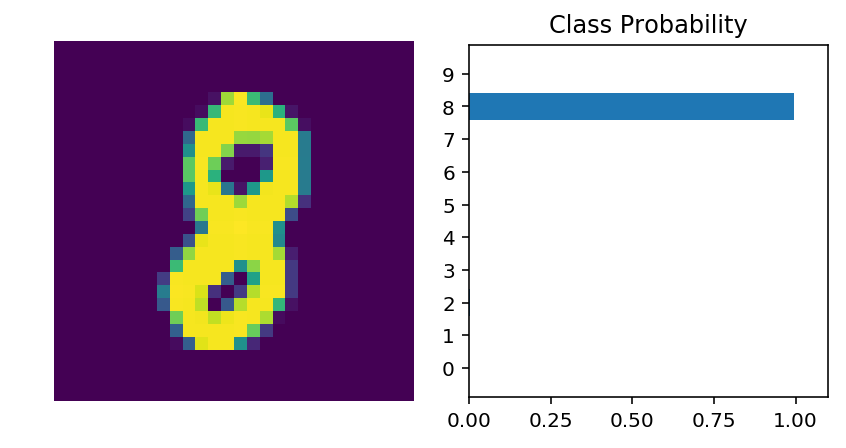

In [16]:
img = images[2]
ps = net.predict(Variable(img.resize_(1, 784)))
helper.view_classify(img.resize_(1, 28, 28), ps)

我们的网络现在并不是一无所知了。它可以准确地预测图像中的数字。接着，你将编写用更复杂的数据集训练神经网络的代码。